In [1]:
import pandas as pd
import numpy as np


In [2]:
df = pd.read_csv("./data/ad_click_dataset.csv")

In [3]:
df.head()

,id,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click
0,670,User670,22.0,NaN,Desktop,Top,Shopping,Afternoon,1
1,3044,User3044,NaN,Male,Desktop,Top,NaN,NaN,1
2,5912,User5912,41.0,Non-Binary,NaN,Side,Education,Night,1
3,5418,User5418,34.0,Male,NaN,NaN,Entertainment,Evening,1
4,9452,User9452,39.0,Non-Binary,NaN,NaN,Social Media,Morning,0


In [4]:
# Features
# Sparse
# age - bucketize + one-hot
# gender - one-hot
# device_type - one-hot
# ad_position - one-hot
# time_of_day - one-hot

# Dense continuous
# browsing_history - tokenization + pre-trained text model - embedding
# user's ad click rate - numerical
# user's total ad views - numerical
# user's clicked ad IDs - ad related feature computation + average

# Target
# click - binary cross entropy loss

In [5]:
df = df.drop(columns=["id", "full_name"])

df["age"] = df["age"].fillna(df["age"].median())
df["gender"] = df["gender"].fillna("Unknown")
df["device_type"] = df["device_type"].fillna("Unknown")
df["ad_position"] = df["ad_position"].fillna("Unknown")
df["browsing_history"] = df["browsing_history"].fillna("Unknown")
df["time_of_day"] = df["time_of_day"].fillna("Unknown")

In [6]:
df.head()

,age,gender,device_type,ad_position,browsing_history,time_of_day,click
0,22.0,Unknown,Desktop,Top,Shopping,Afternoon,1
1,39.5,Male,Desktop,Top,Unknown,Unknown,1
2,41.0,Non-Binary,Unknown,Side,Education,Night,1
3,34.0,Male,Unknown,Unknown,Entertainment,Evening,1
4,39.0,Non-Binary,Unknown,Unknown,Social Media,Morning,0


In [7]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

X = df.drop(columns=["click"])
y = df["click"]

# 3. Identify categorical / numeric
categorical_cols = [
    "gender",
    "device_type",
    "ad_position",
    "browsing_history",
    "time_of_day",
]
numeric_cols = [c for c in X.columns if c not in categorical_cols]

# 4. Preprocessor: OneHot for cats, passthrough nums
preprocessor = ColumnTransformer(
    transformers=[
        (
            "cat",
            OneHotEncoder(handle_unknown="ignore", sparse_output=False),
            categorical_cols,
        ),
        ("num", "passthrough", numeric_cols),
    ]
)

In [8]:
from sklearn.model_selection import train_test_split

X_train_raw, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
X_val_raw, X_test_raw, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

In [9]:
X_train = preprocessor.fit_transform(X_train_raw)
X_val = preprocessor.transform(X_val_raw)
X_test = preprocessor.transform(X_test_raw)

In [10]:
param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [200, 500],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
}

In [11]:
from sklearn.metrics import (
    make_scorer,
    accuracy_score,
    precision_score,
    recall_score,
    average_precision_score
)

pr_auc_scorer = make_scorer(average_precision_score, greater_is_better=True)

scoring = {
    "accuracy": make_scorer(accuracy_score),
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
    "roc_auc": "roc_auc",
    "pr_auc": pr_auc_scorer,
}

In [12]:
from xgboost import XGBClassifier

clf = XGBClassifier(eval_metric="logloss", random_state=42)

In [13]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring=scoring,
    cv=3,
    refit="pr_auc",
    verbose=2,
    n_jobs=-1,
    return_train_score=True,
)

In [14]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END c

,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'colsample_bytree': [0.8, 1.0], 'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 5, ...], 'n_estimators': [200, 500], ...}"
,scoring,"{'accuracy': make_scorer(a...hod='predict'), 'pr_auc': make_scorer(a...hod='predict'), 'precision': make_scorer(p...hod='predict'), 'recall': make_scorer(r...hod='predict'), ...}"
,n_jobs,-1
,refit,'pr_auc'
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,objective,'binary:logistic'


In [15]:
results = pd.DataFrame(grid_search.cv_results_)

# Select relevant columns
summary = results[
    [
        "param_max_depth",
        "param_learning_rate",
        "param_n_estimators",
        "param_subsample",
        "param_colsample_bytree",
        "mean_test_accuracy",
        "mean_test_precision",
        "mean_test_recall",
        "mean_test_roc_auc",
        "mean_test_pr_auc",
        "mean_train_accuracy",
        "mean_train_precision",
        "mean_train_recall",
        "mean_train_roc_auc",
        "mean_train_pr_auc",
    ]
]

# Sort by AUC
summary = summary.sort_values(by="mean_test_roc_auc", ascending=False)

summary.head(10)


,param_max_depth,param_learning_rate,param_n_estimators,param_subsample,param_colsample_bytree,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_roc_auc,mean_test_pr_auc,mean_train_accuracy,mean_train_precision,mean_train_recall,mean_train_roc_auc,mean_train_pr_auc
71,7,0.10,500,1.0,1.0,0.725430,0.745607,0.876707,0.749090,0.733908,0.891143,0.874052,0.972747,0.960473,0.867937
58,7,0.05,500,0.8,1.0,0.720859,0.740309,0.878904,0.742812,0.729434,0.888285,0.872425,0.970000,0.958414,0.865750
35,7,0.10,500,1.0,0.8,0.718573,0.743226,0.866594,0.741995,0.730805,0.892357,0.876157,0.971758,0.961939,0.869770
22,7,0.05,500,0.8,0.8,0.719002,0.738666,0.878683,0.740319,0.727964,0.882857,0.865422,0.970769,0.954836,0.859123
59,7,0.05,500,1.0,1.0,0.721716,0.730170,0.907252,0.739152,0.722731,0.853643,0.829599,0.975165,0.936885,0.825143
23,7,0.05,500,1.0,0.8,0.722573,0.734222,0.898680,0.737207,0.725660,0.858714,0.836387,0.972967,0.940457,0.831350
68,7,0.10,200,0.8,1.0,0.715859,0.736157,0.877365,0.736631,0.725668,0.874500,0.857411,0.967912,0.949834,0.850754
70,7,0.10,500,0.8,1.0,0.716716,0.747573,0.851870,0.736630,0.733155,0.911714,0.902740,0.968571,0.972538,0.894799
69,7,0.10,200,1.0,1.0,0.720715,0.729215,0.907252,0.736553,0.721869,0.846572,0.821419,0.976264,0.929796,0.817341
34,7,0.10,500,0.8,0.8,0.715859,0.746001,0.853410,0.736157,0.732035,0.909071,0.898016,0.970329,0.970625,0.890657


In [16]:
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
)
print("Best params:", grid_search.best_params_)
print("Best CV AUC:", grid_search.best_score_)

# Refit best model on full train
best_model = grid_search.best_estimator_
test_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
print("Test AUC:", test_auc)

test_acc = accuracy_score(y_test, best_model.predict(X_test))
print("Test Accuracy:", test_acc)

test_prec = precision_score(y_test, best_model.predict(X_test))
print("Test Precision:", test_prec)

test_rec = recall_score(y_test, best_model.predict(X_test))
print("Test Recall:", test_rec)

test_ap = average_precision_score(y_test, best_model.predict_proba(X_test)[:, 1])
print("Test AP:", test_ap)


Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500, 'subsample': 1.0}
Best CV AUC: 0.7339080974489517
Test AUC: 0.7793084249084249
Test Accuracy: 0.7493333333333333
Test Precision: 0.7588591184096802
Test Recall: 0.9005128205128206
Test AP: 0.8492840329449831


In [17]:
import pandas as pd

# --- 1) Predictions ---
# Probabilities for positive class
y_proba = best_model.predict_proba(X_test)[:, 1]
# Class predictions at threshold 0.5 (adjust if you want)
y_pred = (y_proba >= 0.5).astype(int)

# --- 2) Confusion Matrix ---
from plotly import graph_objects as go
import plotly.express as px

cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Pred 0", "Pred 1"])

fig_cm = px.imshow(
    cm_df.values,
    x=cm_df.columns,
    y=cm_df.index,
    text_auto=True,
    color_continuous_scale="Blues",
    aspect="equal",
    title="Confusion Matrix (threshold = 0.5)",
)
fig_cm.update_layout(coloraxis_showscale=False)
fig_cm.show()

# --- 3) ROC Curve + AUC ---
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

fig_roc = go.Figure()
fig_roc.add_trace(
    go.Scatter(x=fpr, y=tpr, mode="lines", name=f"ROC (AUC={roc_auc:.3f})")
)
fig_roc.add_trace(
    go.Scatter(x=[0, 1], y=[0, 1], mode="lines", name="Chance", line=dict(dash="dash"))
)
fig_roc.update_layout(
    title="ROC Curve",
    xaxis_title="False Positive Rate",
    yaxis_title="True Positive Rate",
    yaxis=dict(scaleanchor=None, scaleratio=None),
)
fig_roc.show()

# --- 4) Precision-Recall Curve + PRAUC (Average Precision) ---
prec, rec, _ = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)
pos_rate = np.mean(y_test)  # baseline for PR curve

fig_pr = go.Figure()
fig_pr.add_trace(go.Scatter(x=rec, y=prec, mode="lines", name=f"PR (AP={ap:.3f})"))
fig_pr.add_trace(
    go.Scatter(
        x=[0, 1],
        y=[pos_rate, pos_rate],
        mode="lines",
        name=f"Baseline (pos rate={pos_rate:.3f})",
        line=dict(dash="dash"),
    )
)
fig_pr.update_layout(
    title="Precision–Recall Curve",
    xaxis_title="Recall",
    yaxis_title="Precision",
    yaxis=dict(range=[0, 1]),
    xaxis=dict(range=[0, 1]),
)
fig_pr.show()


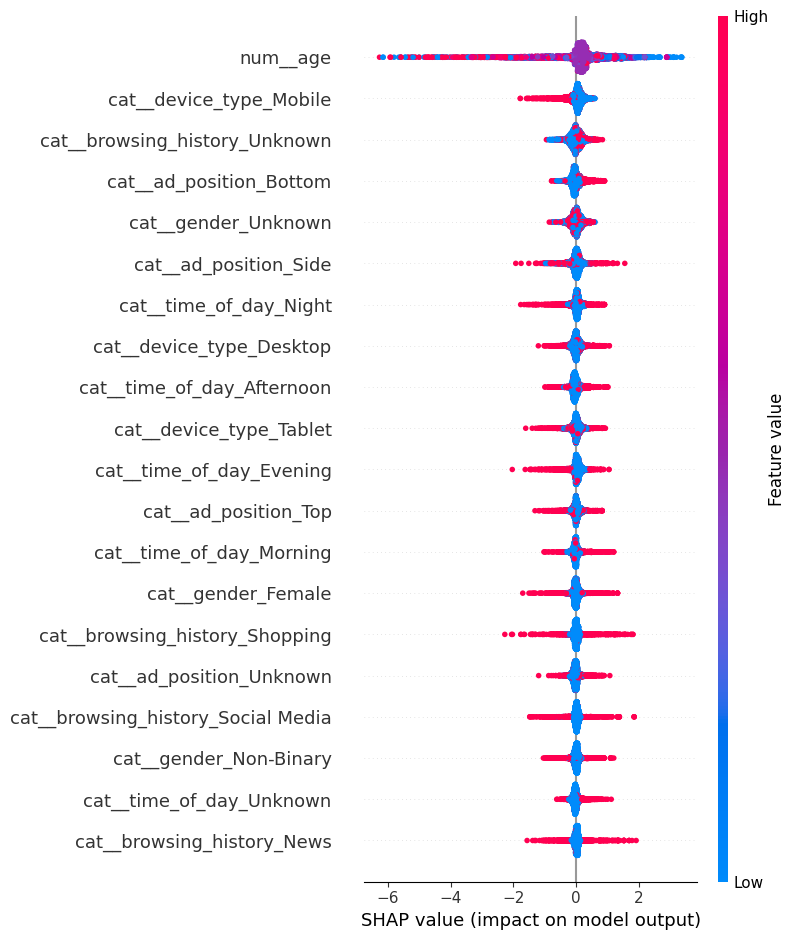

In [18]:
feature_names = preprocessor.get_feature_names_out()
# Wrap back into DataFrames
import pandas as pd

X_train_df = pd.DataFrame(X_train.toarray() if hasattr(X_train, "toarray") else X_train,
                          columns=feature_names)
X_val_df   = pd.DataFrame(X_val.toarray() if hasattr(X_val, "toarray") else X_val,
                          columns=feature_names)
X_test_df  = pd.DataFrame(X_test.toarray() if hasattr(X_test, "toarray") else X_test,
                           columns=feature_names)

import shap
import xgboost as xgb
import matplotlib.pyplot as plt

# Assuming your trained model is called `best_model` (from GridSearchCV)
# And your training data is X_train_df (with column names)

# Convert to DMatrix (if not already)
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_train_df.columns.tolist())

# Create SHAP explainer
explainer = shap.TreeExplainer(grid_search.best_estimator_)
shap_values = explainer.shap_values(X_train)

# --- 1. Summary plot (beeswarm)
shap.summary_plot(shap_values, X_train_df, plot_type="dot")

import pandas as pd
import plotly.express as px
import numpy as np

# Mean absolute SHAP value for each feature
feature_importance = pd.DataFrame({
    "feature": X_train_df.columns,
    "importance": np.abs(shap_values).mean(axis=0)
}).sort_values("importance", ascending=False)

fig = px.bar(feature_importance, x="importance", y="feature", orientation="h",
             title="SHAP Feature Importance", height=600)
fig.show()

